In [1]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 37.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=04c06666df7c27b80b33ea16442491967ec2e555a507ffd4ae656466b0511055
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [2]:
!cp -r drive/MyDrive/Data .

In [3]:
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook, tnrange, tqdm
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, recall_score, precision_score
from utils import *
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
df_x_train, df_y_train, df_x_val, df_y_val, df_x_test = load_data()

In [5]:
df_x_train['text'] = df_x_train['Conclusion']+' '+df_x_train['Stance']+' '+df_x_train['Premise']
df_x_val['text'] = df_x_val['Conclusion']+' '+df_x_val['Stance']+' '+df_x_val['Premise']
df_x_train['text'] = df_x_train['text'].str.lower()
df_x_val['text'] = df_x_val['text'].str.lower()
x_train = df_x_train['text'].to_numpy()
x_val = df_x_val['text'].to_numpy()
y_train = df_y_train.loc[:, df_y_train.columns != 'Argument ID'].to_numpy()
y_val = df_y_val.loc[:, df_y_val.columns != 'Argument ID'].to_numpy()

In [17]:
train_emb = get_emb('labse', x_train)
val_emb = get_emb('labse', x_val)

In [51]:
class feedforward(nn.Module):
    
    def __init__(self, n_classes, emb_size):
        super(feedforward, self).__init__()
        self.fc1 = nn.Linear(emb_size, 512)
        self.dense1_bn = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dense2_bn = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dense3_bn = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 64)
        self.dense4_bn = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(64, n_classes)
        self.sigm = nn.Sigmoid()


    def forward(self, x):
        # x = self.dropout1(F.relu(self.dense1_bn(self.fc1(x))))
        # x = self.dropout2(F.relu(self.dense2_bn(self.fc2(x))))
        # x = self.dropout3(F.relu(self.dense3_bn(self.fc3(x))))
        # x = self.dropout4(F.relu(self.dense4_bn(self.fc4(x))))
        x = self.dropout1(F.relu(self.dense1_bn(self.fc1(x))))
        x = (F.relu(self.dense2_bn(self.fc2(x))))
        x = (F.relu(self.dense3_bn(self.fc3(x))))
        x = (F.relu(self.dense4_bn(self.fc4(x))))
        # x = (F.relu((self.fc1(x))))
        # x = (F.relu((self.fc2(x))))
        # x = (F.relu((self.fc3(x))))
        # x = (F.relu((self.fc4(x))))
        x = self.fc5(x)
        return self.sigm(x)

In [52]:
def train(model, train_x, train_y, n_epochs, criterion, optimizer, batch_size):
    
    train = torch.utils.data.TensorDataset(train_x, train_y)

    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    model = model.train()

    epoch = 0
    while True:
        batch_losses = []
        for x, y in train_loader:
            x.to(device)
            y.to(device)
    
            optimizer.zero_grad()
    
            out = model(x)
            loss = criterion(out, y.type(torch.float))
    
            batch_loss_value = loss.item()
            loss.backward()
            optimizer.step()
    
            batch_losses.append(batch_loss_value)
    
        loss_value = np.mean(batch_losses)
        print("epoch:{:2d} train: loss:{:.3f}".format(epoch, loss_value))

        epoch += 1
        if n_epochs < epoch:
            break
        
    return model

def test(model, test_x, test_y, batch_size):

    test = torch.utils.data.TensorDataset(test_x, test_y)

    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

    model = model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x.to(device)
            out = model(x)
            out = torch.where(out>=0.5, 1, 0)
            for i in out.cpu().numpy():
                preds.append(i)
            for i in y.cpu().numpy():
                targets.append(i)

    preds = np.asarray(preds)
    targets = np.asarray(targets)
    return preds, targets

In [55]:
n_epochs = 20
model = feedforward(20, val_emb.shape[1])
criterion = nn.BCELoss()
batch_size = 10
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_x = torch.tensor(train_emb)
train_y = torch.tensor(y_train)
test_x = torch.tensor(val_emb)
test_y = torch.tensor(y_val)

model = train(model, train_x, train_y, n_epochs, criterion, optimizer, batch_size)
preds, targets = test(model, test_x, test_y, batch_size)

epoch: 0 train: loss:0.397
epoch: 1 train: loss:0.350
epoch: 2 train: loss:0.340
epoch: 3 train: loss:0.332
epoch: 4 train: loss:0.325
epoch: 5 train: loss:0.323
epoch: 6 train: loss:0.319
epoch: 7 train: loss:0.317
epoch: 8 train: loss:0.315
epoch: 9 train: loss:0.311
epoch:10 train: loss:0.308
epoch:11 train: loss:0.306
epoch:12 train: loss:0.303
epoch:13 train: loss:0.302
epoch:14 train: loss:0.301
epoch:15 train: loss:0.299
epoch:16 train: loss:0.296
epoch:17 train: loss:0.294
epoch:18 train: loss:0.292
epoch:19 train: loss:0.292
epoch:20 train: loss:0.290


,0
f1-macro,0.324881
f1-micro,0.476920
f1-weighted,0.442446
f1 on class Self-direction: thought,0.363158
f1 on class Self-direction: action,0.463158
f1 on class Stimulation,0.054422
f1 on class Hedonism,0.201681
f1 on class Achievement,0.598690
f1 on class Power: dominance,0.093750
f1 on class Power: resources,0.144578


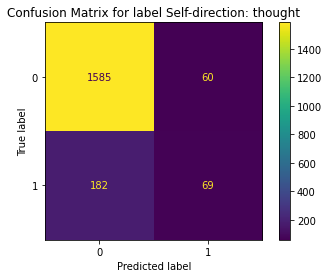

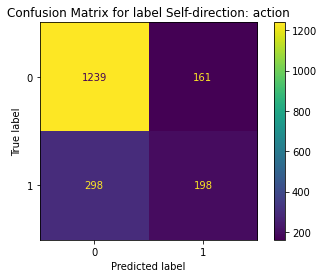

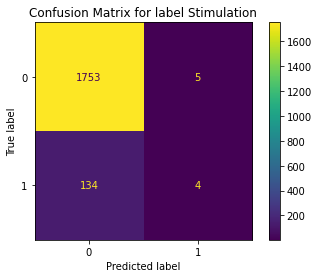

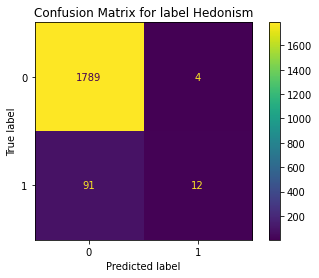

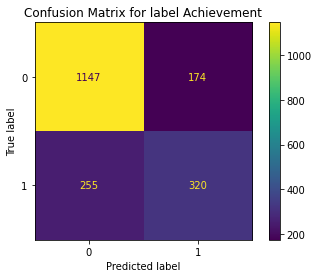

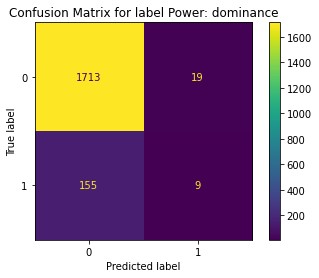

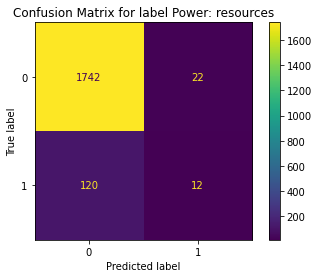

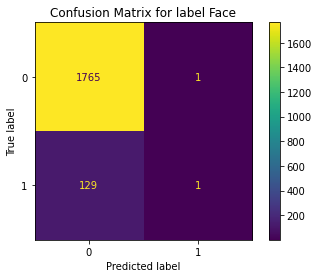

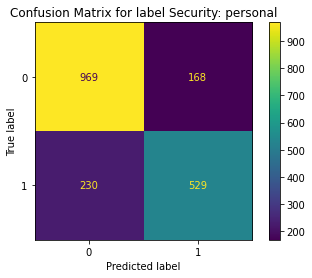

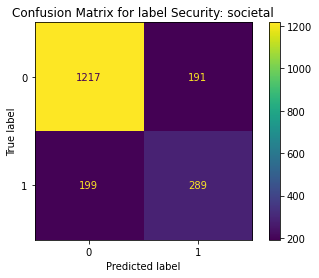

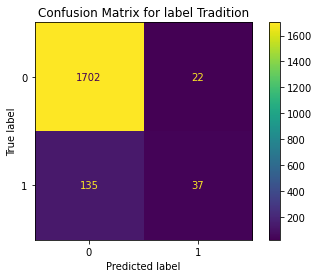

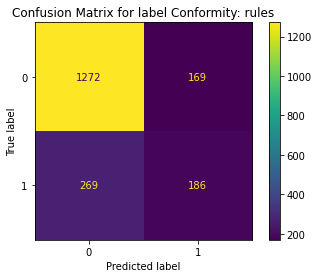

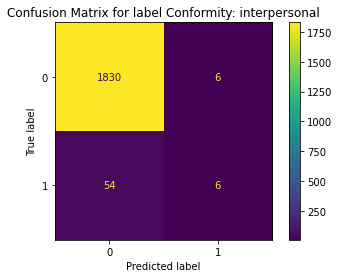

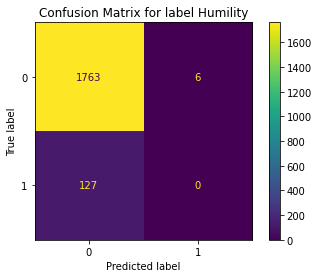

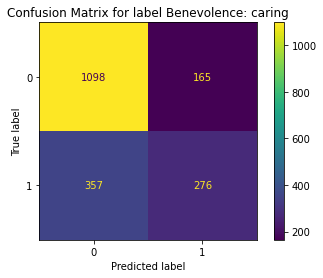

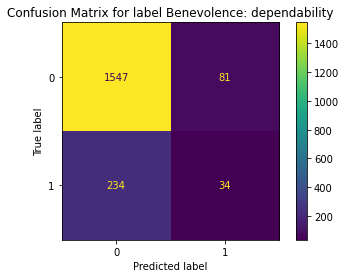

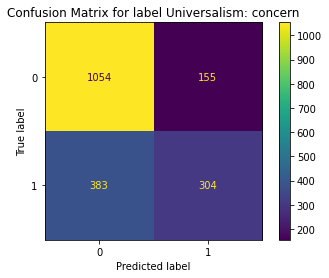

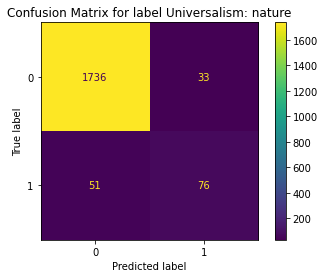

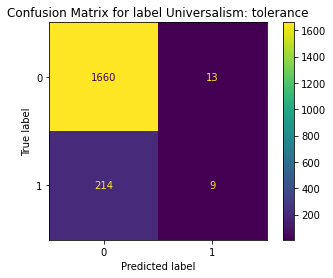

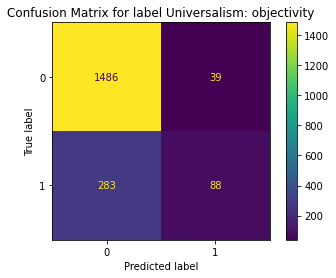

In [56]:
!rm -rf FeedForward-labse
evaluate('FeedForward-labse', preds, targets)

In [57]:
!zip -r FeedForward-labse.zip FeedForward-labse

  adding: FeedForward-labse/ (stored 0%)
  adding: FeedForward-labse/res.tex (deflated 66%)
  adding: FeedForward-labse/Confusion_Universalism: nature.png (deflated 9%)
  adding: FeedForward-labse/Confusion_Tradition.png (deflated 9%)
  adding: FeedForward-labse/Confusion_Universalism: concern.png (deflated 10%)
  adding: FeedForward-labse/Confusion_Power: resources.png (deflated 9%)
  adding: FeedForward-labse/Confusion_Self-direction: action.png (deflated 8%)
  adding: FeedForward-labse/Confusion_Stimulation.png (deflated 10%)
  adding: FeedForward-labse/Confusion_Conformity: rules.png (deflated 9%)
  adding: FeedForward-labse/Confusion_Security: personal.png (deflated 9%)
  adding: FeedForward-labse/Confusion_Benevolence: dependability.png (deflated 9%)
  adding: FeedForward-labse/Confusion_Face.png (deflated 9%)
  adding: FeedForward-labse/Confusion_Security: societal.png (deflated 9%)
  adding: FeedForward-labse/Confusion_Universalism: tolerance.png (deflated 9%)
  adding: FeedFor